In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import re
from pprint import pprint

thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime']
#color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#color_cycle = color_cycle + color_cycle
#color_cycle = color_cycle + color_cycle

debug = 1
g = 0

print('ok')

ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.2 seconds.


# Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 139.2 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 13.7 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# States with 7 or more districts (start process, but rescue from file soon)

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

## Get what has been matched so far

In [6]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_6.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} block groups from previously-matched states in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))


reading districts that have been matched so far...
Read 217,739 block groups from previously-matched states in 0.6 seconds!


### Create function to mark block groups with the districts they overlap

In [7]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')


defined district-marking function!


## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [8]:
s = time.time()

# print('getting from backup...')
# bg_gdf = bg_gdf_bk
# assembler_gdf = assembler_gdf_bk

e = time.time()
g = g + (e-s)

for this_state in ['AL', 'CO', 'SC']:
    s = time.time()
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)
    
    
    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        
    
    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')
        
    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))
    
    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1
    
    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=False)
    if (debug > 0):
        print("\n")
    e = time.time()
    g = g + (e-s)

    print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

print('backing up...')
assembler_gdf_justparsed = assembler_gdf

print('GRAND TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

assembler_gdf[assembler_gdf['STUSAB'].isin(['AL','CO','SC'])].groupby('nDistricts').size()




Processing Alabama...
	Assigning bitmask values to block groups in Alabama...
		processing row 1 of 3,438...
		processing row 101 of 3,438...
		processing row 201 of 3,438...
		processing row 301 of 3,438...
		processing row 401 of 3,438...
		processing row 501 of 3,438...
		processing row 601 of 3,438...
		processing row 701 of 3,438...
		processing row 801 of 3,438...
		processing row 901 of 3,438...
		processing row 1,001 of 3,438...
		processing row 1,101 of 3,438...
		processing row 1,201 of 3,438...
		processing row 1,301 of 3,438...
		processing row 1,401 of 3,438...
		processing row 1,501 of 3,438...
		processing row 1,601 of 3,438...
		processing row 1,701 of 3,438...
		processing row 1,801 of 3,438...
		processing row 1,901 of 3,438...
		processing row 2,001 of 3,438...
		processing row 2,101 of 3,438...
		processing row 2,201 of 3,438...
		processing row 2,301 of 3,438...
		processing row 2,401 of 3,438...
		processing row 2,501 of 3,438...
		processing row 2,601 of 3,438.

nDistricts
1    9740
2     288
3       1
dtype: int64

### Rescue from the file we saved after we accidentally deleted before

In [9]:
# assembler_gdf = assembler_gdf_justparsed
# nDistricts = 7

# fixed_df = pandas.read_csv(data_dir+'block_group_with_district_1_7_rescue.csv', index_col='GEOID')

# for this_state in ['AL','CO','SC']:
#     repaired_districts_s = assembler_gdf[
#         (assembler_gdf['STUSAB'] == this_state)
#         & (assembler_gdf['nDistricts'] > 1)
#     ][
#         ['nDistricts', 'congressional_districts_bitmask']
#      ].join(fixed_df[
#             (fixed_df['STUSAB'] == this_state)
#             & (fixed_df['nDistricts'] > 1)
#             ]['block_based_district']
#           )['block_based_district']

#     print('##### {0:}'.format(this_state))
#     for k in range(1, nDistricts+1):
#         for thisdistrict in repaired_districts_s[repaired_districts_s == k].index:
#             print("assembler_gdf.loc['{0:}', 'block_based_district'] = {1:.0f}".format(thisdistrict, k))


### Fixes for block groups that overlap multiple districts

In [10]:
##### AL
assembler_gdf.loc['15000US010259579021', 'block_based_district'] = 1
assembler_gdf.loc['15000US010259578005', 'block_based_district'] = 1
assembler_gdf.loc['15000US010259578002', 'block_based_district'] = 1
assembler_gdf.loc['15000US010259578001', 'block_based_district'] = 1
assembler_gdf.loc['15000US010259578006', 'block_based_district'] = 1
assembler_gdf.loc['15000US010259579023', 'block_based_district'] = 1
assembler_gdf.loc['15000US010259579024', 'block_based_district'] = 1
assembler_gdf.loc['15000US011010010001', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010010002', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010013001', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010014001', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010015001', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010056101', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010056111', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010059014', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010059011', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010057001', 'block_based_district'] = 2
assembler_gdf.loc['15000US011010054083', 'block_based_district'] = 3
assembler_gdf.loc['15000US011010054081', 'block_based_district'] = 3
assembler_gdf.loc['15000US011010054084', 'block_based_district'] = 3
assembler_gdf.loc['15000US011010054064', 'block_based_district'] = 3
assembler_gdf.loc['15000US011010054082', 'block_based_district'] = 3
assembler_gdf.loc['15000US010199557022', 'block_based_district'] = 3
assembler_gdf.loc['15000US011250103023', 'block_based_district'] = 4
assembler_gdf.loc['15000US011250102011', 'block_based_district'] = 4
assembler_gdf.loc['15000US011250106012', 'block_based_district'] = 4
assembler_gdf.loc['15000US011250103011', 'block_based_district'] = 4
assembler_gdf.loc['15000US011250104062', 'block_based_district'] = 4
assembler_gdf.loc['15000US011250104071', 'block_based_district'] = 4
assembler_gdf.loc['15000US011250104072', 'block_based_district'] = 4
assembler_gdf.loc['15000US010090503002', 'block_based_district'] = 4
assembler_gdf.loc['15000US010719511005', 'block_based_district'] = 5
assembler_gdf.loc['15000US010719511004', 'block_based_district'] = 5
assembler_gdf.loc['15000US010719507003', 'block_based_district'] = 5
assembler_gdf.loc['15000US010730107063', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730141021', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730142043', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730142033', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730123052', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730123054', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730123042', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730111042', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730059104', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730144131', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730119013', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730059033', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730124023', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730107021', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730107042', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730024004', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730120024', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730123021', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730111046', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730108022', 'block_based_district'] = 6
assembler_gdf.loc['15000US010730048001', 'block_based_district'] = 7
assembler_gdf.loc['15000US011250112001', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730023034', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730055002', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730023052', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730125002', 'block_based_district'] = 7
assembler_gdf.loc['15000US010259579011', 'block_based_district'] = 7
assembler_gdf.loc['15000US011010013002', 'block_based_district'] = 7
assembler_gdf.loc['15000US011010015002', 'block_based_district'] = 7
assembler_gdf.loc['15000US011010030002', 'block_based_district'] = 7
assembler_gdf.loc['15000US011250104031', 'block_based_district'] = 7
assembler_gdf.loc['15000US011250103031', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730059102', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730141042', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730138012', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730059032', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730121031', 'block_based_district'] = 7
assembler_gdf.loc['15000US011250105002', 'block_based_district'] = 7
assembler_gdf.loc['15000US011250106013', 'block_based_district'] = 7
assembler_gdf.loc['15000US011250103012', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730035001', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730120012', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730024005', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730120023', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730121035', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730123051', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730124011', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730059031', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730124021', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730125003', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730023033', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730139011', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730024006', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730141041', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730111041', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730112071', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730035003', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730112091', 'block_based_district'] = 7
assembler_gdf.loc['15000US010259575002', 'block_based_district'] = 7
assembler_gdf.loc['15000US010259580011', 'block_based_district'] = 7
assembler_gdf.loc['15000US011250126001', 'block_based_district'] = 7
assembler_gdf.loc['15000US010259579022', 'block_based_district'] = 7
assembler_gdf.loc['15000US010730118022', 'block_based_district'] = 7
assembler_gdf.loc['15000US011010060004', 'block_based_district'] = 7
assembler_gdf.loc['15000US011010022012', 'block_based_district'] = 7
##### CO
assembler_gdf.loc['15000US080590120223', 'block_based_district'] = 1
assembler_gdf.loc['15000US080050064003', 'block_based_district'] = 1
assembler_gdf.loc['15000US080590120543', 'block_based_district'] = 1
assembler_gdf.loc['15000US080050055531', 'block_based_district'] = 1
assembler_gdf.loc['15000US080310070132', 'block_based_district'] = 1
assembler_gdf.loc['15000US080050066013', 'block_based_district'] = 1
assembler_gdf.loc['15000US080370006001', 'block_based_district'] = 2
assembler_gdf.loc['15000US080930001003', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590120381', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590120393', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590120411', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590120412', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590120421', 'block_based_district'] = 2
assembler_gdf.loc['15000US080370005033', 'block_based_district'] = 2
assembler_gdf.loc['15000US080370005031', 'block_based_district'] = 2
assembler_gdf.loc['15000US080370004012', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590098082', 'block_based_district'] = 2
assembler_gdf.loc['15000US080130132052', 'block_based_district'] = 2
assembler_gdf.loc['15000US080130132131', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590098084', 'block_based_district'] = 2
assembler_gdf.loc['15000US080130132112', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590098453', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590098502', 'block_based_district'] = 2
assembler_gdf.loc['15000US080590120362', 'block_based_district'] = 2
assembler_gdf.loc['15000US080370004011', 'block_based_district'] = 3
assembler_gdf.loc['15000US080370005022', 'block_based_district'] = 3
assembler_gdf.loc['15000US080370001001', 'block_based_district'] = 3
assembler_gdf.loc['15000US080370005021', 'block_based_district'] = 3
assembler_gdf.loc['15000US080350141351', 'block_based_district'] = 4
assembler_gdf.loc['15000US080130132122', 'block_based_district'] = 4
assembler_gdf.loc['15000US080130132111', 'block_based_district'] = 4
assembler_gdf.loc['15000US081230020051', 'block_based_district'] = 4
assembler_gdf.loc['15000US081230020073', 'block_based_district'] = 4
assembler_gdf.loc['15000US080050071043', 'block_based_district'] = 4
assembler_gdf.loc['15000US080350139012', 'block_based_district'] = 4
assembler_gdf.loc['15000US080930002002', 'block_based_district'] = 5
assembler_gdf.loc['15000US080350139013', 'block_based_district'] = 6
assembler_gdf.loc['15000US080350141372', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050066014', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050067122', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050830001', 'block_based_district'] = 6
assembler_gdf.loc['15000US080350141373', 'block_based_district'] = 6
assembler_gdf.loc['15000US080350141312', 'block_based_district'] = 6
assembler_gdf.loc['15000US080010083531', 'block_based_district'] = 6
assembler_gdf.loc['15000US080010084011', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050832001', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050071062', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050860003', 'block_based_district'] = 6
assembler_gdf.loc['15000US080010085241', 'block_based_district'] = 6
assembler_gdf.loc['15000US080010085245', 'block_based_district'] = 6
assembler_gdf.loc['15000US080350141341', 'block_based_district'] = 6
assembler_gdf.loc['15000US080350141402', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050872001', 'block_based_district'] = 6
assembler_gdf.loc['15000US080010600001', 'block_based_district'] = 6
assembler_gdf.loc['15000US080350139011', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050071052', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050071061', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050056122', 'block_based_district'] = 6
assembler_gdf.loc['15000US080050056191', 'block_based_district'] = 6
assembler_gdf.loc['15000US080010085232', 'block_based_district'] = 6
assembler_gdf.loc['15000US080590098493', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590605003', 'block_based_district'] = 7
assembler_gdf.loc['15000US080010085361', 'block_based_district'] = 7
assembler_gdf.loc['15000US080010085371', 'block_based_district'] = 7
assembler_gdf.loc['15000US080010085261', 'block_based_district'] = 7
assembler_gdf.loc['15000US080010085455', 'block_based_district'] = 7
assembler_gdf.loc['15000US080010085242', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590117241', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590098491', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590117203', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590120541', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590119042', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590120414', 'block_based_district'] = 7
assembler_gdf.loc['15000US080590117311', 'block_based_district'] = 7
assembler_gdf.loc['15000US080010085351', 'block_based_district'] = 7
##### SC
assembler_gdf.loc['15000US450150209031', 'block_based_district'] = 1
assembler_gdf.loc['15000US450350105031', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150203024', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150208121', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150204041', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150206002', 'block_based_district'] = 1
assembler_gdf.loc['15000US450130002001', 'block_based_district'] = 1
assembler_gdf.loc['15000US450130022021', 'block_based_district'] = 1
assembler_gdf.loc['15000US450130004001', 'block_based_district'] = 1
assembler_gdf.loc['15000US450130003002', 'block_based_district'] = 1
assembler_gdf.loc['15000US450130005011', 'block_based_district'] = 1
assembler_gdf.loc['15000US450130003003', 'block_based_district'] = 1
assembler_gdf.loc['15000US450130003001', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150203022', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150204031', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150205032', 'block_based_district'] = 1
assembler_gdf.loc['15000US450190051002', 'block_based_district'] = 1
assembler_gdf.loc['15000US450150203012', 'block_based_district'] = 1
assembler_gdf.loc['15000US450790026032', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790114111', 'block_based_district'] = 2
assembler_gdf.loc['15000US450750116004', 'block_based_district'] = 2
assembler_gdf.loc['15000US450750116003', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790114191', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790101033', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790103092', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790113053', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790114113', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790102003', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790102002', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790111011', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790113054', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790101021', 'block_based_district'] = 2
assembler_gdf.loc['15000US450750119002', 'block_based_district'] = 2
assembler_gdf.loc['15000US450750119003', 'block_based_district'] = 2
assembler_gdf.loc['15000US450750120003', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790103043', 'block_based_district'] = 2
assembler_gdf.loc['15000US450790027001', 'block_based_district'] = 2
assembler_gdf.loc['15000US450719507003', 'block_based_district'] = 3
assembler_gdf.loc['15000US450719505021', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450033031', 'block_based_district'] = 3
assembler_gdf.loc['15000US450719507002', 'block_based_district'] = 3
assembler_gdf.loc['15000US450719506013', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450030092', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450030091', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450033041', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450028161', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450030142', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450030131', 'block_based_district'] = 3
assembler_gdf.loc['15000US450450033043', 'block_based_district'] = 3
assembler_gdf.loc['15000US450830224033', 'block_based_district'] = 4
assembler_gdf.loc['15000US450450030051', 'block_based_district'] = 4
assembler_gdf.loc['15000US450450028162', 'block_based_district'] = 4
assembler_gdf.loc['15000US450450036021', 'block_based_district'] = 4
assembler_gdf.loc['15000US450450036022', 'block_based_district'] = 4
assembler_gdf.loc['15000US450830224012', 'block_based_district'] = 4
assembler_gdf.loc['15000US450830224041', 'block_based_district'] = 4
assembler_gdf.loc['15000US450830224043', 'block_based_district'] = 4
assembler_gdf.loc['15000US450450030111', 'block_based_district'] = 4
assembler_gdf.loc['15000US450450030132', 'block_based_district'] = 4
assembler_gdf.loc['15000US450450033032', 'block_based_district'] = 4
assembler_gdf.loc['15000US450719505025', 'block_based_district'] = 5
assembler_gdf.loc['15000US450719502025', 'block_based_district'] = 5
assembler_gdf.loc['15000US450719505024', 'block_based_district'] = 5
assembler_gdf.loc['15000US450719506012', 'block_based_district'] = 5
assembler_gdf.loc['15000US450850016001', 'block_based_district'] = 5
assembler_gdf.loc['15000US450850008002', 'block_based_district'] = 5
assembler_gdf.loc['15000US450850020001', 'block_based_district'] = 5
assembler_gdf.loc['15000US450830224011', 'block_based_district'] = 5
assembler_gdf.loc['15000US450850004005', 'block_based_district'] = 5
assembler_gdf.loc['15000US450790026031', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150203021', 'block_based_district'] = 6
assembler_gdf.loc['15000US450350108012', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790101034', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790101031', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790116071', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790114121', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790116081', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150204012', 'block_based_district'] = 6
assembler_gdf.loc['15000US450190031042', 'block_based_district'] = 6
assembler_gdf.loc['15000US450190054002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450190022001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450190022002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450190031073', 'block_based_district'] = 6
assembler_gdf.loc['15000US450190007002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790111013', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150201021', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150201022', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790030001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790116083', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850006003', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850011002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850013001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850006002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850004006', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850011003', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790011002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790011004', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790013003', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150203011', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150201012', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790027002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450790027003', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150202012', 'block_based_district'] = 6
assembler_gdf.loc['15000US450410023003', 'block_based_district'] = 6
assembler_gdf.loc['15000US450410024001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450410020003', 'block_based_district'] = 6
assembler_gdf.loc['15000US450410020004', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850015001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450190031092', 'block_based_district'] = 6
assembler_gdf.loc['15000US450150210001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450299708001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450299708002', 'block_based_district'] = 6
assembler_gdf.loc['15000US450850006001', 'block_based_district'] = 6
assembler_gdf.loc['15000US450410020001', 'block_based_district'] = 7
assembler_gdf.loc['15000US450410018003', 'block_based_district'] = 7
print('Done!')

Done!


In [11]:
s = time.time()
print('Fixing for continuity and closest matching...')

print('Fixing Alabama...')
assembler_gdf.loc[['15000US010730112071', '15000US010730112091'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US010730059033', '15000US010730142033', '15000US010730123051'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US011010010002', '15000US010730111042'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US010259579022'], 'block_based_district'] = 1
print('Fixing Colorado...')
assembler_gdf.loc[['15000US080140311002'], 'block_based_district'] = 2   #  was 2
assembler_gdf.loc[['15000US080590605003'], 'block_based_district'] = 7   # was 7
assembler_gdf.loc[['15000US080310120143'], 'block_based_district'] = 7    # was 1
assembler_gdf.loc[['15000US080590120412'], 'block_based_district'] = 7    # was 1
assembler_gdf.loc[['15000US080590120223'], 'block_based_district'] = 2   # was 1
assembler_gdf.loc[['15000US080050071043'], 'block_based_district'] = 6   # was 4
print('Fixing South Carolina...')
assembler_gdf.loc[['15000US450750119003'], 'block_based_district'] = 6   #  was 2
assembler_gdf.loc[['15000US450790114111'], 'block_based_district'] = 6   #  was 2
assembler_gdf.loc[['15000US450790114121', '15000US450790027002', '15000US450790027003', '15000US450790026031', '15000US450790111013'], 'block_based_district'] = 2   #  was 6
assembler_gdf.loc[['15000US450130003001', '15000US450130003002', '15000US450130005011', '15000US450130003003', '15000US450130002001'], 'block_based_district'] = 6   #  was 1
assembler_gdf.loc[['15000US450190031073'], 'block_based_district'] = 6 # = 6
assembler_gdf.loc[['15000US450150204041', '15000US450150206002'], 'block_based_district'] = 6 # was 1

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))


Fixing for continuity and closest matching...
Fixing Alabama...
Fixing Colorado...
Fixing South Carolina...
Kept 217,739 block groups in 0.0 seconds!


In [12]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_7.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 51,230 block groups in 0 minutes 2 seconds!
GRAND TOTAL TIME: 27  minutes 17 seconds!


In [13]:
z = pandas.read_csv(output_dir+'block_group_with_district_1_7.csv', encoding='utf-8', index_col='GEOID')


#z.head(1).T
z.shape

(51230, 21)

In [14]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_7.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')

e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 128.1 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 5.7 seconds


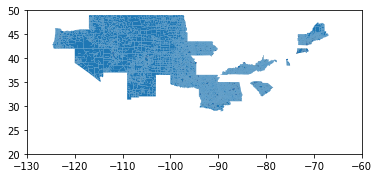

In [15]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()



## SOUTH CAROLINA

In [16]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'SC')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # 1 and 6 (x1000010)    36
# # 2 and 6 (x0100010)    33
# # 3 and 4 (x0011000)    15
# # 3 and 5 (x0010100)     8
# # 4 and 5 (x0001100)     5
# # 5 and 6 (x0000110)    12
# # 6 and 7 (x0000011)     6

In [17]:
# s = time.time()

# this_state = 'SC'
# test_this_bitmask = 'x0000011'

# manual_plot_limits = False
# show_small_roads = False

# manual_xlim = (-80.945, -80.885)
# manual_ylim = (34.06, 34.165)

# legend_location = 'lower left'

# buffer_percent = 0.05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))


# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * buffer_percent
#     ybuffer = yspan * buffer_percent
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=11, ha='center'
#                )
    
# print('plotting water...')
# water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# plt.show()

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])
    
# explore_more = b

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


In [18]:
### Further investigation    


In [19]:
# s = time.time()
# label_small_roads = True
# label_small_road_types = ['Rd', 'St', 'Ave'] 
# basesize = 8
# aspect_ratio = xspan / yspan

# i = 0
# this_block_group_id = explore_more[i]

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0 }
# other_roads = []

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
# total_block_group_area = block_group_geo.area
# print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))
# print('\n')

# print('Finding roads in this block group...')
# road_linearids_in_this_block_group_list = []
# cnt = 0
# for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
#     if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
#         print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
#     if (thisrow.geometry.intersects(block_group_geo)):
#         road_linearids_in_this_block_group_list.append(ix)
#     cnt = cnt + 1

# print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
# print('\n')

# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
#         this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
#         this_district_overlap_area = this_district_overlap_geo.area
#         print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
#         match_road_network_length = 0
#         for jx, thatrow in roads_gdf[
#             (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersects(this_district_overlap_geo)):
#                 match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
#         road_network_density = ((match_road_network_length)**2) / this_district_overlap_area
#         print('\tDistrict {0:} overlap has {1:,.1f} km roads (density {2:,.1f})...'.format(i, match_road_network_length/1000, road_network_density))
#         print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# print('Plotting official districts...')

# legend_list = []
# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
# print('plotting tracts that overlap multiple districts...')
# assembler_gdf[
#     assembler_gdf.index == this_block_group_id
# ].plot(ax=ax, color='none', edgecolor='white', linewidth=10)

# bounding_box = unary_union(
#     assembler_gdf[
#         assembler_gdf.index == this_block_group_id
#     ].geometry.tolist()
# ).bounds
# xlimits = (bounding_box[0], bounding_box[2])
# ylimits = (bounding_box[1], bounding_box[3])

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]

# xbuffer = xspan * buffer_percent
# ybuffer = yspan * buffer_percent

# ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
# ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
# #ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    

# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=0.5) 
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=3)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=5)

# print('labeling roads...')
# unique_names = []
# for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
#     has_custom_bbox = False
#     thefontdict = {}
#     labelsize = 9
#     annotator = ''
#     if (thisrow['RTTYP'] == 'I'):
#         labelsize = 20
#         annotator = thisrow['RTTYP']
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="darrow", fc='white', ec='blue')
#     elif (thisrow['RTTYP'] == 'U'):
#         labelsize = 16
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="square", fc='white', ec='red')
#     elif (thisrow['RTTYP'] == 'S'):
#         if ('42-679' in thisrow['FULLNAME']):
#             labelsize = 14
#             annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#             has_custom_bbox = True
#             thebbox=dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')
#     elif (thisrow['RTTYP'] == 'C'):
#         labelsize = 10
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="sawtooth,pad=1", fc='white')
#     elif (label_small_roads):
#         labelsize = 9
#         if (thisrow['FULLNAME'] not in unique_names):
#             unique_names.append(thisrow['FULLNAME'])
#             if (re.search("\s",str(thisrow['FULLNAME'])) != None):
#                 road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1]
#                 is_other_road_type = True
#                 for k, v in suffixes_to_count_dict.items():
#                     if (road_suffix == k):
#                         suffixes_to_count_dict[k] = suffixes_to_count_dict[k] + 1
#                         is_other_road_type = False
#                 if (is_other_road_type):
#                     other_roads.append(thisrow['FULLNAME'])
#                 if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#                     annotator = thisrow['FULLNAME']
#     if (has_custom_bbox):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
#                      bbox = thebbox)
#     else:
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# # print('plotting places...')
# # place_gdf[place_gdf.geometry.apply(lambda x: x.intersects(assembler_gdf.loc[this_block_group_id].geometry))].plot(ax=ax, color='purple', edgecolor='none')
    
    
# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))
# print('\n')
# plt.show()



# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #  6


In [20]:
# for ix, thisrow in place_gdf.iterrows():
#     if thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry):
#         print(thisrow['NAME'])
#         print('\n')

### Read water areas, places, roads

In [21]:
# s = time.time()

# this_state = 'SC'
# this_state_number = 45
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy


## COLORADO

## Assign districts to block groups that overlap multiple districts

See examination sections below

In [22]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'CO')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


# # 1 and 2 (x1100000)   3
# # 1 and 6 (x1000010)   9
# # 1 and 7 (x1000001)   4
# # 2 and 3 (x0110000)   8
# # 2 and 4 (x0101000)   7
# # 2 and 5 (x0100100)   2
# # 2 and 7 (x0100001)  14
# # 4 and 6 (x0001010)  18
# # 6 and 7 (x0000011)  10

In [23]:
# s = time.time()

# this_state = 'CO'
# test_this_bitmask = 'x0000011'

# manual_plot_limits = False
# show_small_roads = True
# manual_xlim = (-104.77,-104.62)
# manual_ylim = (39.6,39.71)

# legend_location = 'upper right'

# buffer_percent = 0.05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))


# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * buffer_percent
#     ybuffer = yspan * buffer_percent
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=11, ha='center'
#                )
    
# print('plotting water...')
# water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=2) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=3) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=5) 

# plt.show()

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])
    
# explore_more = b

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))




#### Further investigation of specific block groups

In [24]:
# s = time.time()
# label_small_roads = False
# basesize = 8
# aspect_ratio = xspan / yspan
# #legend_location = 'lower left'

# i = 0
# this_block_group_id = '15000US080010085245' #explore_more[i]


# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))
# print('\n')

# block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
# total_block_group_area = block_group_geo.area
# print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))

# print('Finding roads in this block group...')
# road_linearids_in_this_block_group_list = []
# cnt = 0
# for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
#     if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
#         print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
#     if (thisrow.geometry.intersects(block_group_geo)):
#         road_linearids_in_this_block_group_list.append(ix)
#     cnt = cnt + 1

# print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
# print('\n')

# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
#         this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
#         this_district_overlap_area = this_district_overlap_geo.area
#         print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
#         match_road_network_length = 0
#         for jx, thatrow in roads_gdf[
#             (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersects(this_district_overlap_geo)):
#                 match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
#         road_network_density = ((match_road_network_length)**2) / this_district_overlap_area
#         print('\tDistrict {0:} overlap has {1:,.1f} km roads (density {2:,.1f})...'.format(i, match_road_network_length/1000, road_network_density))
#         print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# print('Plotting official districts...')

# legend_list = []
# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
# print('plotting tracts that overlap multiple districts...')
# assembler_gdf[
#     assembler_gdf.index == this_block_group_id
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

# bounding_box = unary_union(
#     assembler_gdf[
#         assembler_gdf.index == this_block_group_id
#     ].geometry.tolist()
# ).bounds
# xlimits = (bounding_box[0], bounding_box[2])
# ylimits = (bounding_box[1], bounding_box[3])

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# # xlimits = (bounding_box[0] - map_buffer, bounding_box[2] + map_buffer)
# # ylimits = (bounding_box[1] - map_buffer, bounding_box[3] + map_buffer)
# xbuffer = xspan * buffer_percent
# ybuffer = yspan * buffer_percent

# ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
# ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    

# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')

# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=0.5) 
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=3)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=5)

# print('labeling roads...')
# #unique_names = []
# for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
#     has_custom_bbox = False
#     thefontdict = {}
#     labelsize = 9
#     annotator = ''
#     if (thisrow['RTTYP'] == 'I'):
#         labelsize = 20
#         annotator = thisrow['RTTYP']
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="round", ec='blue')
#     elif (thisrow['RTTYP'] == 'U'):
#         labelsize = 16
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="round", ec='red')
#     elif (thisrow['RTTYP'] == 'S'):
#         labelsize = 14
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="round", ec='pink')
#     elif (thisrow['RTTYP'] == 'C'):
#         labelsize = 10
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="sawtooth,pad=1",fc='white')
#     elif (label_small_roads):
#         labelsize = 9
#         annotator = thisrow['FULLNAME']
#         #print(roads_gdf.to_crs(equal_area_crs).loc[ix].geometry.length)
#         #if (thisrow['FULLNAME'] not in unique_names):
#          #   unique_names.append(thisrow['FULLNAME'])
# #            if (re.search('Foshee|Air Base|Day|Fairview|Mobile|Terminal',str(thisrow['FULLNAME'])) != None):
# #            if (str(thisrow['FULLNAME'])[-2:] != 'St'):
            
# #             if (str(thisrow['FULLNAME'])[-2:] == 'St'):
# #                 annotator = '$\it{0:}$'.format(thisrow['FULLNAME'][:-2])
# #             else:
# #                 annotator = thisrow['FULLNAME']
#     if (has_custom_bbox):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
#                      bbox = thebbox)
#     else:
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

# print('\n')
# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))
# print('\n')
# plt.show()

# print(this_block_group_id)

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

## Get water, places, roads

In [25]:
# s = time.time()

# this_state = 'CO'
# this_state_number = 8
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy


# ALABAMA

In [26]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'AL')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # 2 and 3 and 7 (x0110001)     1

# # 1 and 7 (x1000001)    11

# # 2 and 3 (x0110000)     7
# # 2 and 7 (x0100001)    12
# # 3 and 4 (x0011000)     1
# # 4 x0001100     3
# # x0001010     1
# # x0001001    14
# # x0000011    49

#### Establishing shot

In [27]:
# #

# s = time.time()

# this_state = 'AL'
# test_this_bitmask = 'x0000011'

# manual_plot_limits = False
# show_small_roads = True
# manual_xlim = (-86.75,-86.61)
# manual_ylim = (33.575,33.685)

# buffer_percent = 0.05
# legend_location = 'lower right'

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))


# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * buffer_percent
#     ybuffer = yspan * buffer_percent
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=11, ha='center'
#                )
    
# print('plotting water...')
# water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=2) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=3) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=5) 

# plt.show()

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])
    
# explore_more = b

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



#### Further investigation of specific block groups

In [28]:
# s = time.time()
# label_small_roads = False
# basesize = 8
# aspect_ratio = xspan / yspan
# #legend_location = 'lower left'

# i = 0
# this_block_group_id = explore_more[i]


# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))
# print('\n')

# block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
# total_block_group_area = block_group_geo.area
# print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))

# print('Finding roads in this block group...')
# road_linearids_in_this_block_group_list = []
# cnt = 0
# for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
#     if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
#         print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
#     if (thisrow.geometry.intersects(block_group_geo)):
#         road_linearids_in_this_block_group_list.append(ix)
#     cnt = cnt + 1

# print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
# print('\n')

# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
#         this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
#         this_district_overlap_area = this_district_overlap_geo.area
#         print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
#         match_road_network_length = 0
#         for jx, thatrow in roads_gdf[
#             (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersects(this_district_overlap_geo)):
#                 match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
#         road_network_density = ((match_road_network_length)**2) / this_district_overlap_area
#         print('\tDistrict {0:} overlap has {1:,.1f} km roads (density {2:,.1f})...'.format(i, match_road_network_length/1000, road_network_density))
#         print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# print('Plotting official districts...')

# legend_list = []
# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
# print('plotting tracts that overlap multiple districts...')
# assembler_gdf[
#     assembler_gdf.index == this_block_group_id
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

# bounding_box = unary_union(
#     assembler_gdf[
#         assembler_gdf.index == this_block_group_id
#     ].geometry.tolist()
# ).bounds
# xlimits = (bounding_box[0], bounding_box[2])
# ylimits = (bounding_box[1], bounding_box[3])

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# # xlimits = (bounding_box[0] - map_buffer, bounding_box[2] + map_buffer)
# # ylimits = (bounding_box[1] - map_buffer, bounding_box[3] + map_buffer)
# xbuffer = xspan * buffer_percent
# ybuffer = yspan * buffer_percent

# ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
# ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    

# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')

# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=0.5) 
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=3)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
#     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=5)

# print('labeling roads...')
# #unique_names = []
# for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
#     has_custom_bbox = False
#     thefontdict = {}
#     labelsize = 9
#     annotator = ''
#     if (thisrow['RTTYP'] == 'I'):
#         labelsize = 20
#         annotator = thisrow['RTTYP']
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="round", ec='blue')
#     elif (thisrow['RTTYP'] == 'U'):
#         labelsize = 16
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="round", ec='red')
# #     elif (thisrow['RTTYP'] == 'S'):
# #         labelsize = 14
# #         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
# #         has_custom_bbox = True
# #         thebbox=dict(boxstyle="round", ec='pink')
# #     elif (thisrow['RTTYP'] == 'C'):
# #         labelsize = 10
# #         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
# #         has_custom_bbox = True
# #         thebbox=dict(boxstyle="sawtooth,pad=1",fc='white')
#     elif (label_small_roads):
#         labelsize = 9
#         annotator = thisrow['FULLNAME']
#         #print(roads_gdf.to_crs(equal_area_crs).loc[ix].geometry.length)
#         #if (thisrow['FULLNAME'] not in unique_names):
#          #   unique_names.append(thisrow['FULLNAME'])
# #            if (re.search('Foshee|Air Base|Day|Fairview|Mobile|Terminal',str(thisrow['FULLNAME'])) != None):
# #            if (str(thisrow['FULLNAME'])[-2:] != 'St'):
            
# #             if (str(thisrow['FULLNAME'])[-2:] == 'St'):
# #                 annotator = '$\it{0:}$'.format(thisrow['FULLNAME'][:-2])
# #             else:
# #                 annotator = thisrow['FULLNAME']
#     if (has_custom_bbox):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
#                      bbox = thebbox)
#     else:
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

# print('\n')
# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=k'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))
# print('\n')
# plt.show()

# print(this_block_group_id)

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

#### Get water areas, places, roads

In [29]:
# s = time.time()

# this_state = 'AL'
# this_state_number = 1
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy
